# News Classsification

## About the Dataset

This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

### Content

Each record in the dataset consists of the following attributes:

    category: category in which the article was published.
    headline: the headline of the news article.
    authors: list of authors who contributed to the article.
    link: link to the original news article.
    short_description: Abstract of the news article.
    date: publication date of the article.

There are a total of 42 news categories in the dataset. The top-15 categories and corresponding article counts are as follows:

    POLITICS: 35602

    WELLNESS: 17945

    ENTERTAINMENT: 17362

    TRAVEL: 9900

    STYLE & BEAUTY: 9814

    PARENTING: 8791

    HEALTHY LIVING: 6694

    QUEER VOICES: 6347

    FOOD & DRINK: 6340

    BUSINESS: 5992

    COMEDY: 5400

    SPORTS: 5077

    BLACK VOICES: 4583

    HOME & LIVING: 4320

    PARENTS: 3955


## Objective:

The objective is to classify the news articles in one of the following categories:-
1. POLITICS
2. ENTERTAINMENT
3. WELLNESS
4. TRAVEL
5. SPORTS
6. STYLE & BEAUTY

## Proposed Solution

We will be using a pre-trained model BERT, and the Hugging Face library for fine tuning. <br>
Steps:-
1. Exploratory Data Analysis
2. Data Preprocessing & Feature Engineering
   -  Converting all text to lower-case
   -  Removing all stop words and punctuations from text.
   -  Tokenization
3. Setting up Pytorch with GPUs available
4. Model Building
5. Model Evaluation
   -  Accuracy
   -  F1 Score
   -  Precision
   -  Recall

# Import Necessary Libraries

In [107]:
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch
from datasets import Dataset
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import nltk
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load Dataset

In [76]:
# Loading dataset into pandas dataframe
df = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines = True)

In [77]:
# view top 5 rows
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


Clearly, we need to do some preprocessing to te able to use this data for news classification.

# EDA

In [78]:
# Descriptive statistics of dataset
df.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [79]:
sorted(df['category'].unique())

['ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'U.S. NEWS',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

'The WORLDPOST' and 'WORLDPOST' should be considered the same.

In [80]:
df['category'].replace('THE WORLDPOST','WORLDPOST',inplace = True)

In [81]:
sorted(df['category'].unique())

['ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'TRAVEL',
 'U.S. NEWS',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

In [82]:
len(df['category'].unique())

41

* Data set has 41 unique news categories. 
* 209527 records

Text(0.5, 1.0, 'Number of words in description')

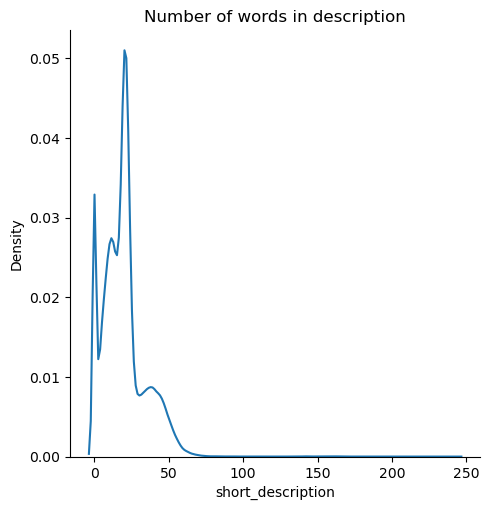

In [83]:
DescNumberOfWords = df['short_description'].apply(lambda x: len(str(x).split()))
df['desc_length'] = DescNumberOfWords
sns.displot(DescNumberOfWords, kind = 'kde')
plt.title("Number of words in description")

* Some articles have no short description.

In [84]:
DescNumberOfWords.value_counts()[0]

19712

* 19712 out of 209,527 articles, have no headline.

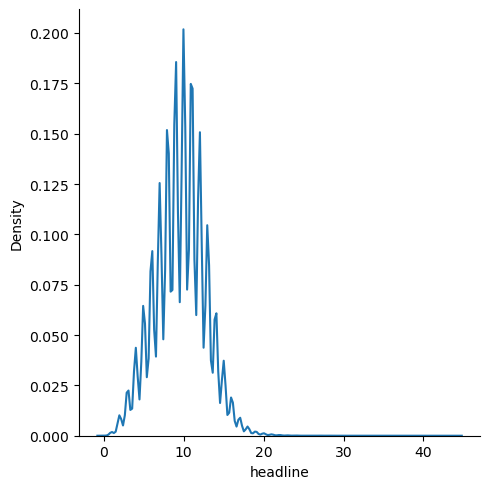

In [85]:
HeadlineNumberOfWords = df['headline'].apply(lambda x: len(str(x).split()))
df['headline_length'] = HeadlineNumberOfWords
sns.displot(HeadlineNumberOfWords, kind = 'kde')

* Few articles have no headline.

In [86]:
# Number of articles without headline
HeadlineNumberOfWords.value_counts()[0]

6

* Only 6 out of 209,527 articles, have no headline.

In [87]:
# Number of articles with no headline and short description
df[(df['desc_length'] == 0) & (df['headline_length'] == 0)].count()[0]

5

* There are only 5 out of 209,527 articles, with no headline and short description.

In [88]:
# Dropping rows with both headline and short description missing.
df = df[(df['desc_length'] != 0) | (df['headline_length'] != 0)].copy()

In [89]:
df[(df['desc_length'] == 0) & (df['headline_length'] == 0)].count()[0]

0

All records in which both short description and headline are missing have been removed.

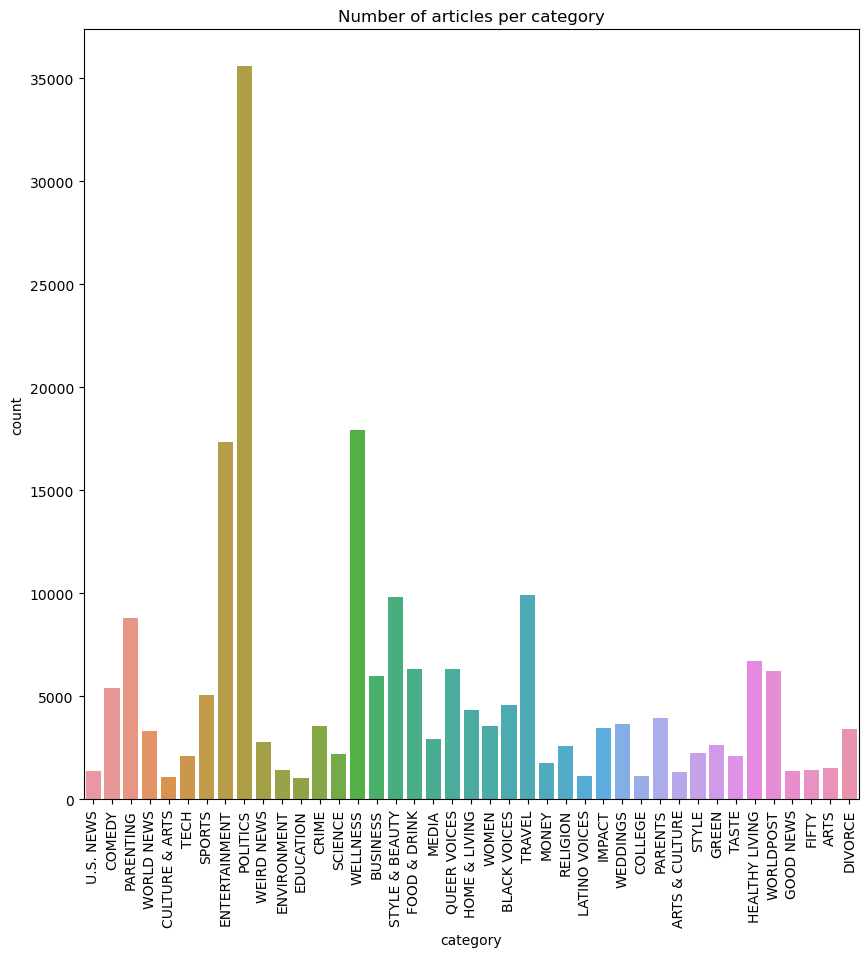

In [90]:
plt.figure(figsize=(10,10))
sns.countplot(data=df, x='category')
plt.xticks(rotation = 90)
plt.title("Number of articles per category")
plt.show()

# Preprocessing & Feature Engineering

In [91]:
print(f"{df['headline'][0]}\n\n {df['short_description'][0]}")

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters

 Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.


In [92]:
# Add full-stop as end of headlines
df['headline'] = df['headline'] + '.'

In [93]:
# Create a new feature 'text' which is concatenation of headline and short_description.
df['text'] = df['headline'] + df['short_description']

In [94]:
print(f"{df['headline'][0]}\n\n {df['short_description'][0]}\n\n {df['text'][0]}")

Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters.

 Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.

 Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters.Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.


In [95]:
# Create a subset of dataframe for building our model, we don't need all features
dataset = df[['text','category']].copy()

In [96]:
# Renaming category to labels
dataset.rename({'category':'labels'},axis=1, inplace = True)

In [98]:
dataset['text'][0]

'over 4 million americans roll up sleeves for omicron-targeted covid boosters.health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the u.s. ordered for the fall.'

In [105]:
# Remove stop words and punctuations
def preprocess_text(text):
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # tokenize text
    tokens = word_tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]
    # convert to lowercase
    tokens = [token.lower() for token in tokens]
    # join tokens back into text
    text = ' '.join(tokens)
    return text

In [108]:
dataset['text'] = dataset['text'].apply(preprocess_text)

In [110]:
dataset.to_csv("CleanedData.csv")

In [111]:
dataset['text'][0]

'4 million americans roll sleeves omicrontargeted covid boostershealth experts said early predict whether demand would match 171 million doses new boosters us ordered fall'

In [112]:
dataset.head()

,text,labels
0,4 million americans roll sleeves omicrontarget...,U.S. NEWS
1,american airlines flyer charged banned life pu...,U.S. NEWS
2,23 funniest tweets cats dogs week sept 1723unt...,COMEDY
3,funniest tweets parents week sept 1723accident...,PARENTING
4,woman called cops black birdwatcher loses laws...,U.S. NEWS


## Tokenization

In [113]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
def tokenize_function(inp):
    return tokenizer(inp['text'], padding='max_length', truncation=True)

def make_dataloader(labs, size_train, size_test, batch_size):
    train_per_label = int(size_train / len(labs))
    test_per_label = int(size_test / len(labs))
    size = train_per_label + test_per_label
    
    train_dataset = pd.DataFrame()
    test_dataset = pd.DataFrame()
    
    for l in labs:
        add = dataset[dataset['labels'] == l].sample(size)
        train_add = add.head(train_per_label)
        test_add = add.tail(test_per_label)
        train_dataset = pd.concat([train_dataset, train_add])
        test_dataset = pd.concat([test_dataset, test_add])
        
    train_dataset = train_dataset.sample(frac=1)
    test_dataset = test_dataset.sample(frac=1)
    
    label_encoder = LabelEncoder().fit(train_dataset['labels'])
    train_dataset['labels'] = label_encoder.transform(train_dataset['labels'])
    test_dataset['labels'] = label_encoder.transform(test_dataset['labels'])
    
    train_dataset = Dataset.from_pandas(train_dataset)
    test_dataset = Dataset.from_pandas(test_dataset)
    
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    tokenized_train = tokenized_train.remove_columns(['__index_level_0__', 'text'])
    tokenized_test = tokenized_test.remove_columns(['__index_level_0__', 'text'])

    tokenized_train.set_format('torch')
    tokenized_test.set_format('torch')

    train_dataloader = DataLoader(tokenized_train, batch_size=batch_size)
    test_dataloader = DataLoader(tokenized_test, batch_size=batch_size)
    
    return train_dataloader, test_dataloader, label_encoder

# Model Building

In [114]:
import torch
print(torch.cuda.device_count())

1


In [115]:
device = torch.device('cuda:0')


def build_a_model(model, optimizer, num_epochs, the_dataloader, the_scheduler, num_training_steps):
    num_training_steps = len(the_dataloader) * num_epochs
    progress_bar = tqdm(range(num_training_steps))
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        for batch in the_dataloader:
            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            the_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
    return model

In [116]:
labels_used = ['POLITICS', 'ENTERTAINMENT', 'WELLNESS', 'TRAVEL', 'SPORTS', 'STYLE & BEAUTY']
train_dataloader, test_dataloader, encoder = make_dataloader(labels_used, 6000, 600, 10)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [117]:
category = list(encoder.classes_)
classes = [i for i in range(len(category))]
encoding = pd.DataFrame({'classes':classes, 'category':category})
encoding.to_pickle('./encoder.pkl')

In [118]:
encoding = dict(zip(encoding['classes'],encoding['category']))

In [119]:
print(encoding)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'SPORTS', 3: 'STYLE & BEAUTY', 4: 'TRAVEL', 5: 'WELLNESS'}


In [120]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(labels_used))
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

model = build_a_model(model, optimizer, num_epochs, train_dataloader, lr_scheduler, num_training_steps)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Model Evaluation

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))
targets = []
predictions = []

model.eval()
for batch in test_dataloader:
    labels = batch['labels'].cpu().numpy()
    batch.pop('labels', None)
    batch = {k:v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    for t, p in zip(labels, preds):
        targets.append(t)
        predictions.append(p)
    progress_bar.update(1)
    
valid_score = accuracy_score(targets, predictions)
print('accuracy of valid is {:.3f}'.format(valid_score))

In [ ]:
recall = recall_score(targets, predictions, average='weighted') # or average='macro'/'micro'
print('Recall score: {:.3f}'.format(recall))

In [ ]:
f1 = f1_score(targets, predictions, average='weighted') # or average='macro'/'micro'
print('F1 score: {:.3f}'.format(f1))

In [ ]:
precision = precision_score(targets, predictions, average='weighted') # or average='macro'/'micro'
print('Precision score: {:.3f}'.format(precision))

In [101]:
# Create a dataframe of actual and predicted values
df = pd.DataFrame({'Actual': targets, 'Predicted': predictions})
df['Actual'] = df['Actual'].apply(lambda x: str(encoding[x]))
df['Predicted'] = df['Predicted'].apply(lambda x: str(encoding[x]))


# Display the dataframe
df.head()

,Actual,Predicted
0,ENTERTAINMENT,WELLNESS
1,ENTERTAINMENT,ENTERTAINMENT
2,SPORTS,SPORTS
3,POLITICS,POLITICS
4,TRAVEL,TRAVEL


In [ ]:
# Save the model
torch.save(model.state_dict(), './model.pt')

# Citations
1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).

# References
- https://huggingface.co/docs/transformers/model_doc/bert
- https://pytorch.org/docs/stable/index.html
- https://scikit-learn.org/0.21/documentation.html